<h1><center>Text classification using torchtext</center></h1>

This notebook was inspired from this [post](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

## Imports

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import text_classification

from torchero import SupervisedTrainer
from torchero.callbacks import ProgbarLogger, StepLR
from torchero.hparams import OptimP
from torchero.utils.data import train_test_split

### Load training dataset dataset ###

First, we download the AG_NEWS train and test datasets

In [2]:
NGRAMS = 2

if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](root='./.data',
                                                                      ngrams=NGRAMS,
                                                                      vocab=None)

120000lines [00:04, 26165.80lines/s]
120000lines [00:08, 14573.27lines/s]
7600lines [00:00, 14692.38lines/s]


We split the training dataset into training and validation

In [3]:
train_dataset, val_dataset = train_test_split(train_dataset, valid_size=0.2)

Then we need to create the dataloaders for train, valid, and test dataset. For the use 

In [4]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return (text, offsets), label

train_dl = DataLoader(train_dataset, 100, collate_fn=generate_batch)
val_dl = DataLoader(val_dataset, 100, collate_fn=generate_batch)
test_dl = DataLoader(test_dataset, collate_fn=generate_batch)

## Model Definition

In [5]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [6]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 64
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS)

### Training

In [7]:
trainer = SupervisedTrainer(model,
                            'cross_entropy',
                            optimizer=SGD(model.parameters(), lr=4.0),
                            callbacks=[ProgbarLogger(notebook=True),
                                       StepLR(1, gamma=0.9)],
                            acc_meters=['categorical_accuracy_percentage'],
                            hparams={'lr': OptimP('lr')},
                            logging_frecuency=10)
trainer.to('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
trainer.train(train_dl, val_dl, epochs=50)

## Metrics ##

In [9]:
trainer.history.to_dataframe()

,epoch,train_acc,train_loss,lr,val_acc,val_loss
0,0,70.913544,0.750695,4.000000,85.933334,0.417719
1,1,88.133331,0.353993,3.600000,88.812500,0.335948
2,2,90.795830,0.279733,3.240000,89.508331,0.308520
3,3,92.328125,0.235825,2.916000,89.991669,0.295180
4,4,93.510414,0.203851,2.624400,90.162498,0.288061
5,5,94.472916,0.178776,2.361960,90.324997,0.284260
6,6,95.277084,0.158461,2.125764,90.462502,0.282327
7,7,95.907288,0.141743,1.913188,90.541664,0.281495
8,8,96.421875,0.127866,1.721869,90.550003,0.281333
9,9,96.861458,0.116285,1.549682,90.599998,0.281576


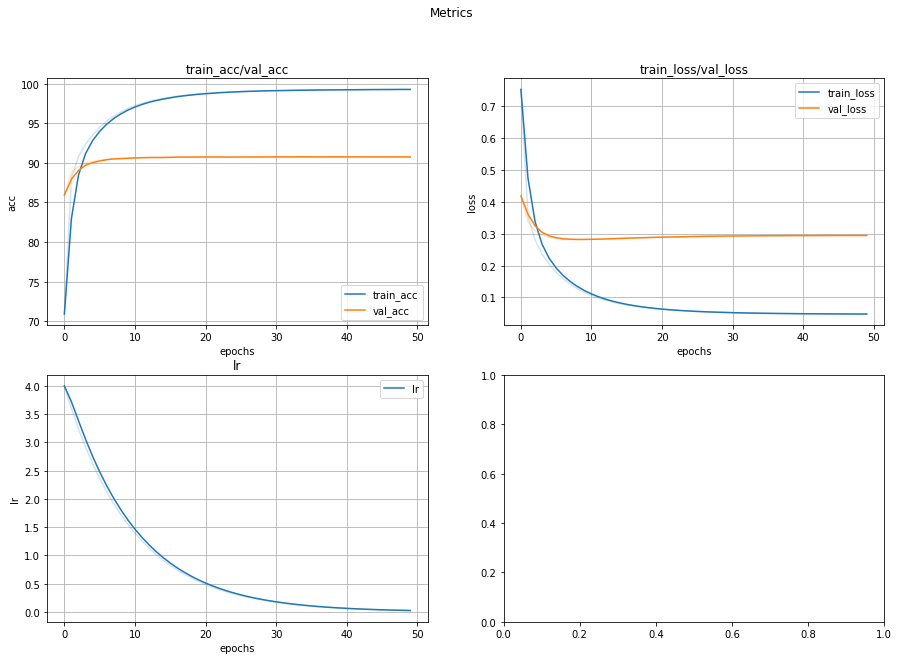

In [10]:
trainer.history.plot(smooth=0.3)
plt.show()

### Test Evaluation ###

In [11]:
results = trainer.evaluate(test_dl, metrics=['categorical_accuracy_percentage',
                                             'confusion_matrix'])

### Accuracy ###

In [12]:
print("Test accuracy:", results['acc'])

Test accuracy: 86.93421173095703


### Confusion Matrix ###

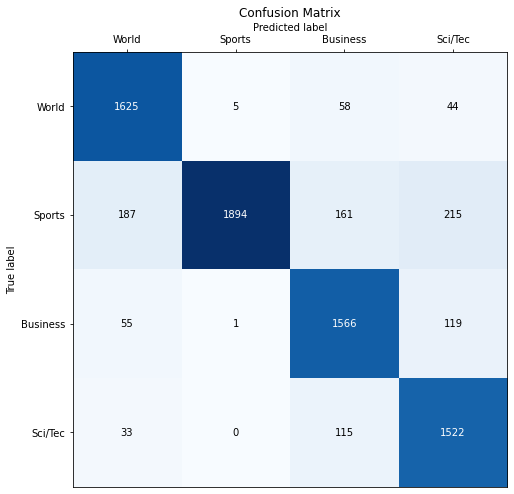

In [13]:
plt.figure(figsize=(8, 8))
results['confusion_matrix'].plot(classes=["World",
                                          "Sports",
                                          "Business",
                                          "Sci/Tec"])
plt.show()